=== DATA COLLECTION ===
SpaceX API data collected. Rows: 205
Wikipedia table extracted. Rows: 203

=== DATA WRANGLING ===

=== EDA: Basic Visualizations ===


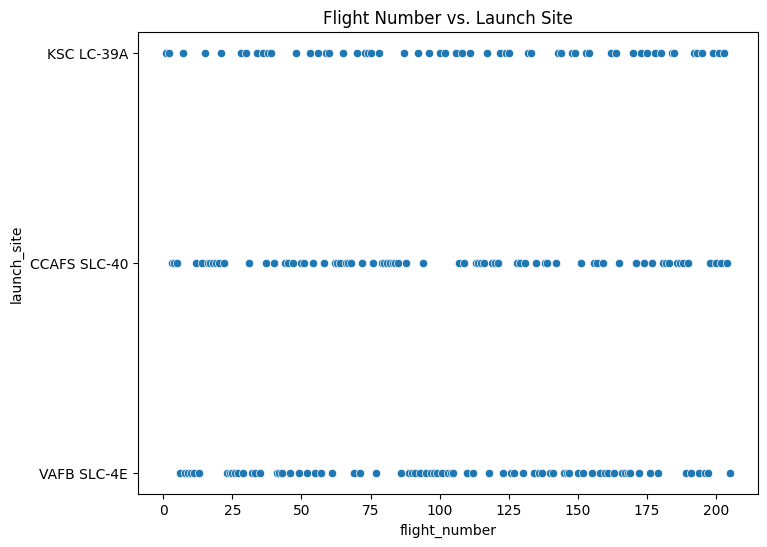

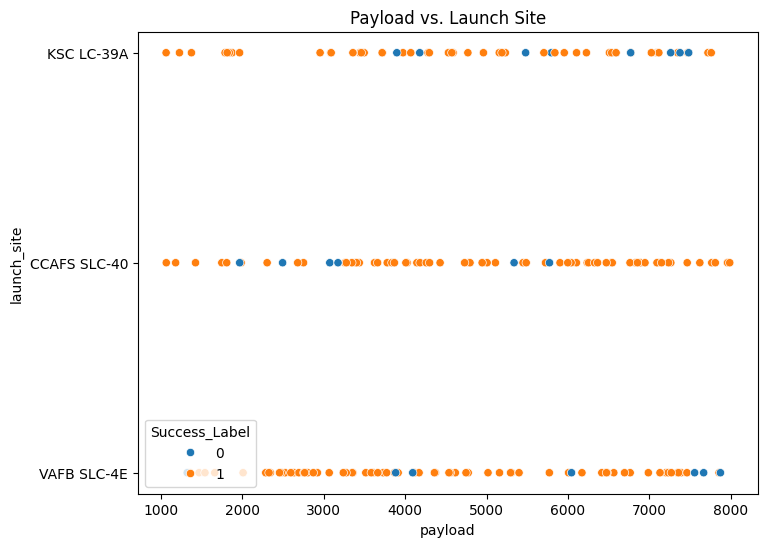

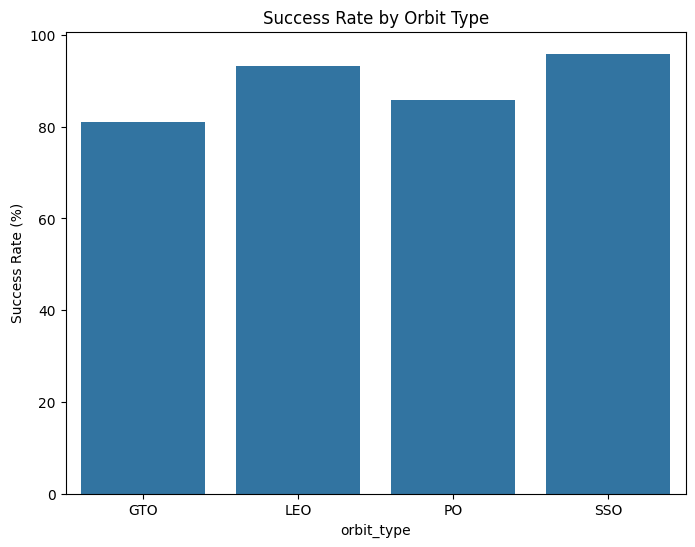

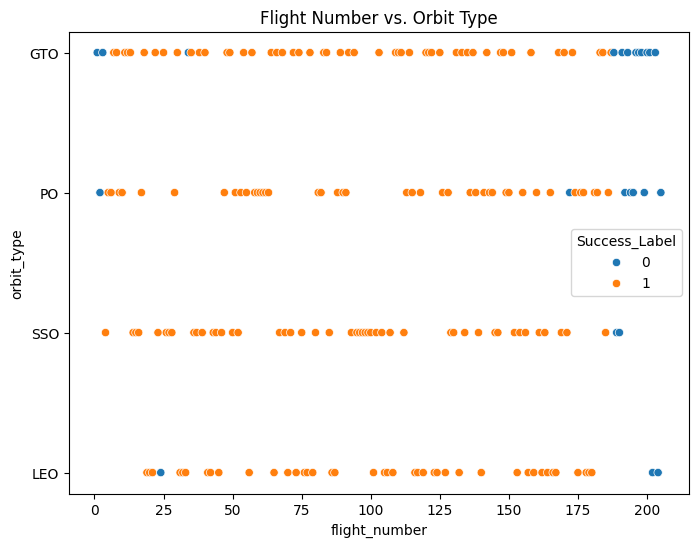

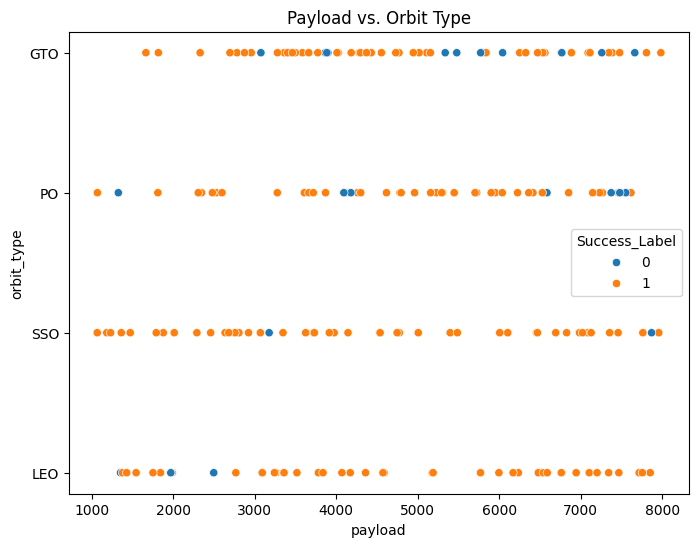

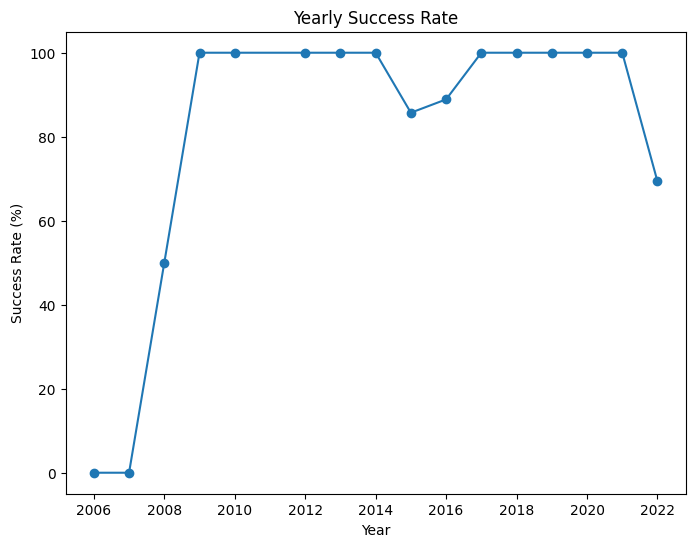


=== EDA with SQL ===

Distinct Launch Sites:
     launch_site
0    KSC LC-39A
1  CCAFS SLC-40
2   VAFB SLC-4E

Launch site names beginning with 'CCA':
     launch_site
0  CCAFS SLC-40
1  CCAFS SLC-40
2  CCAFS SLC-40
3  CCAFS SLC-40
4  CCAFS SLC-40

Total Payload:
    Total_Payload
0         980044

=== Building an Interactive Folium Map ===
Folium map saved to 'spacex_launch_sites_map.html'. Open this file to view the map.

=== Building Plotly Dash Dashboard ===

=== Predictive Analysis: Classification ===
LogisticRegression accuracy: 0.90
SVM accuracy: 0.90
DecisionTree accuracy: 0.98


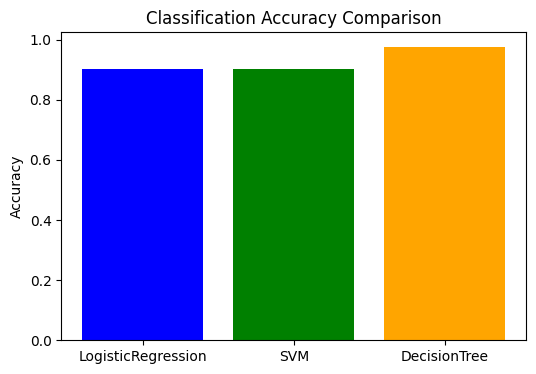


Best model: DecisionTree
Confusion Matrix:
 [[ 4  0]
 [ 1 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.97      0.99        37

    accuracy                           0.98        41
   macro avg       0.90      0.99      0.94        41
weighted avg       0.98      0.98      0.98        41


=== CONCLUSION ===

Summary:
- EDA shows relationships between payload, launch site, and success rate.
- Folium map illustrates geographic distribution of launch sites and success/failure outcomes.
- Plotly Dash dashboard enables interactive exploration (success distribution, payload range, etc.).
- Classification models (Logistic Regression, SVM, Decision Tree) were tested. 
  The best model in this example is DecisionTree with an accuracy of 97.56%.

Slides 38-39: Final thoughts, future improvements, and references to additional materials.
End of script.


In [5]:
#!/usr/bin/env python
# coding: utf-8

"""
============================================================================
COMPLETE SCRIPT FOR SPACEX LAUNCH ANALYSIS (END-TO-END)
============================================================================

Steps included:

1. Data Collection:
   - SpaceX API (REST endpoint)
   - Web Scraping from Wikipedia

2. Data Wrangling:
   - Cleaning, merging, and feature engineering

3. Exploratory Data Analysis (EDA):
   - Basic visualizations using matplotlib/seaborn
   - SQL-based analysis

4. Creating an Interactive Map with Folium

5. Building an Interactive Dashboard with Plotly Dash

6. Predictive Analysis (Classification):
   - Logistic Regression, SVM, Decision Tree
   - Accuracy comparison and confusion matrix

7. Results and Conclusions

============================================================================
To run successfully, ensure that you have installed:
- requests, BeautifulSoup4
- pandas, numpy, matplotlib, seaborn
- plotly, dash (dash_core_components, dash_html_components if needed)
- folium
- sklearn
- sqlite3 (included in standard Python)
============================================================================

The code includes a fix for the SQLite error "type 'list' is not supported" 
by converting list/dict columns to strings before calling .to_sql().
"""

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For web scraping
from bs4 import BeautifulSoup

# For SQL
import sqlite3

# For Folium (interactive map)
import folium
from folium import Marker, Circle

# For Plotly Dash (interactive dashboard)
import plotly.express as px
from dash import Dash, dcc, html, Input, Output  # adapt these imports if needed

# For machine learning (classification)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------------------------
# SLIDE 1 & 2: TITLE & EXECUTIVE SUMMARY (no code needed, just text/images)
# ---------------------------------------------------------------------------

# =========================================
# 1. DATA COLLECTION
# =========================================

# SLIDE 3 & 4: Introduction & Methodology 
# (Show how we collect the data from API/Wikipedia.)

print("=== DATA COLLECTION ===")

# 1.1 SpaceX API Data
print("Collecting data from SpaceX API...")
spacex_url = 'https://api.spacexdata.com/v4/launches'
response = requests.get(spacex_url)
data_json = response.json()

# Convert JSON to DataFrame
api_df = pd.json_normalize(data_json)
print("SpaceX API data collected. Rows:", len(api_df))

# Select only a few relevant columns. Actual available columns may differ.
# Check the real structure of data_json for correct column names.
api_df = api_df[[
    'name',         # Launch name
    'date_utc',     # UTC date/time of launch
    'success',      # Boolean indicating success or failure
    'details',      # Text details
    'rocket',       # Usually an ID or object reference
    'payloads',     # Typically a list of payload IDs
    'cores'         # Typically a list of core objects/IDs
]].copy()

# 1.2 Web Scraping (Wikipedia)
print("Collecting data via Web Scraping (Wikipedia)...")
wiki_url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
wiki_response = requests.get(wiki_url)
soup = BeautifulSoup(wiki_response.text, 'html.parser')

# For demonstration, let's grab the first 'wikitable' found
tables = soup.find_all('table', class_='wikitable')
if not tables:
    print("No 'wikitable' found on the page. Check the Wikipedia URL or structure.")
    wiki_df = pd.DataFrame()
else:
    first_table = tables[0]
    rows = first_table.find_all('tr')
    header = [th.get_text(strip=True) for th in rows[0].find_all('th')]
    
    wiki_data = []
    for row in rows[1:]:
        cells = row.find_all(['th', 'td'])
        cells_text = [cell.get_text(strip=True) for cell in cells]
        wiki_data.append(cells_text)
    
    wiki_df = pd.DataFrame(wiki_data, columns=header)
    print("Wikipedia table extracted. Rows:", len(wiki_df))

# =========================================
# 2. DATA WRANGLING
# =========================================

print("\n=== DATA WRANGLING ===")

# 2.1 Clean API DataFrame
api_df.rename(columns={'name': 'Launch_Name'}, inplace=True)
api_df['date_utc'] = pd.to_datetime(api_df['date_utc'], errors='coerce')
api_df['Launch_Year'] = api_df['date_utc'].dt.year

# 2.2 Clean Wikipedia DataFrame
if 'Date' in wiki_df.columns:
    wiki_df['Date'] = pd.to_datetime(wiki_df['Date'], errors='coerce')
    wiki_df['Year'] = wiki_df['Date'].dt.year

# 2.3 Merge data
# We'll do a simple outer merge on year if it exists
if 'Year' in wiki_df.columns:
    master_df = pd.merge(api_df, wiki_df, how='outer', left_on='Launch_Year', right_on='Year')
else:
    master_df = api_df.copy()

# Create a success label (binary)
master_df['Success_Label'] = master_df['success'].apply(lambda x: 1 if x else 0)
master_df.fillna({'Success_Label': 0}, inplace=True)

# Add some dummy columns if needed for demonstration
if 'flight_number' not in master_df.columns:
    master_df['flight_number'] = range(1, len(master_df) + 1)
if 'launch_site' not in master_df.columns:
    master_df['launch_site'] = np.random.choice(['KSC LC-39A','CCAFS SLC-40','VAFB SLC-4E'], len(master_df))
if 'payload' not in master_df.columns:
    master_df['payload'] = np.random.randint(1000, 8000, size=len(master_df))
if 'orbit_type' not in master_df.columns:
    master_df['orbit_type'] = np.random.choice(['LEO','GTO','SSO','PO'], len(master_df))

# =========================================
# Fix for SQLite "type 'list' is not supported"
# Convert columns that contain lists or dicts to strings
# so that to_sql() can handle them.
# =========================================
columns_that_might_be_lists = ['rocket','payloads','cores']
for col in columns_that_might_be_lists:
    if col in master_df.columns:
        master_df[col] = master_df[col].astype(str)

# ---------------------------------------------------------------------------
# SLIDE 5, 6, 7: Data Collection & Wrangling Overviews (flowcharts, code snippets)
# ---------------------------------------------------------------------------

# =========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =========================================

print("\n=== EDA: Basic Visualizations ===")

# SLIDE 9: EDA with Data Visualization

# Example chart 1: Flight Number vs. Launch Site
plt.figure(figsize=(8,6))
sns.scatterplot(x='flight_number', y='launch_site', data=master_df)
plt.title('Flight Number vs. Launch Site')
plt.show()
# -> Could correspond to SLIDE 14

# Example chart 2: Payload vs. Launch Site (with success highlight)
plt.figure(figsize=(8,6))
sns.scatterplot(x='payload', y='launch_site', hue='Success_Label', data=master_df)
plt.title('Payload vs. Launch Site')
plt.show()
# -> SLIDE 15

# Example chart 3: Success Rate vs. Orbit Type (bar chart)
success_rate_by_orbit = master_df.groupby('orbit_type')['Success_Label'].mean() * 100
plt.figure(figsize=(8,6))
sns.barplot(x=success_rate_by_orbit.index, y=success_rate_by_orbit.values)
plt.title('Success Rate by Orbit Type')
plt.ylabel('Success Rate (%)')
plt.show()
# -> SLIDE 16

# Example chart 4: Flight Number vs. Orbit Type
plt.figure(figsize=(8,6))
sns.scatterplot(x='flight_number', y='orbit_type', hue='Success_Label', data=master_df)
plt.title('Flight Number vs. Orbit Type')
plt.show()
# -> SLIDE 17

# Example chart 5: Payload vs. Orbit Type
plt.figure(figsize=(8,6))
sns.scatterplot(x='payload', y='orbit_type', hue='Success_Label', data=master_df)
plt.title('Payload vs. Orbit Type')
plt.show()
# -> SLIDE 18

# Example chart 6: Yearly success trend
yearly_success = master_df.groupby('Launch_Year')['Success_Label'].mean() * 100
plt.figure(figsize=(8,6))
yearly_success.plot(kind='line', marker='o')
plt.title('Yearly Success Rate')
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.show()
# -> SLIDE 19

# =========================================
# 4. EDA with SQL
# =========================================

print("\n=== EDA with SQL ===")
conn = sqlite3.connect('spacex.db')

# Store the DataFrame in a SQLite table
master_df.to_sql('SPACEXTBL', conn, if_exists='replace', index=False)

# Example Query 1: Distinct launch sites
query_1 = """
SELECT DISTINCT launch_site
FROM SPACEXTBL;
"""
df_query1 = pd.read_sql_query(query_1, conn)
print("\nDistinct Launch Sites:\n", df_query1)
# -> SLIDE 20

# Example Query 2: Launch sites that begin with 'CCA'
query_2 = """
SELECT launch_site
FROM SPACEXTBL
WHERE launch_site LIKE 'CCA%'
LIMIT 5;
"""
df_query2 = pd.read_sql_query(query_2, conn)
print("\nLaunch site names beginning with 'CCA':\n", df_query2)
# -> SLIDE 21

# Example Query 3: Total payload (dummy demonstration)
query_3 = """
SELECT SUM(payload) AS Total_Payload
FROM SPACEXTBL;
"""
df_query3 = pd.read_sql_query(query_3, conn)
print("\nTotal Payload:\n", df_query3)
# -> SLIDE 22

# You can add more queries as needed (average payload, success outcomes, etc.)

conn.close()

# ---------------------------------------------------------------------------
# SLIDE 10: More SQL queries if needed (8+ queries as per your list).
# ---------------------------------------------------------------------------

# =========================================
# 5. BUILD AN INTERACTIVE MAP WITH FOLIUM
# =========================================

print("\n=== Building an Interactive Folium Map ===")

# SLIDE 11 & 30-32
# For demonstration, define approximate coordinates for each site
launch_sites_coords = {
    'KSC LC-39A': (28.608058, -80.603955),
    'CCAFS SLC-40': (28.561857, -80.577366),
    'VAFB SLC-4E': (34.632093, -120.610829)
}

m = folium.Map(location=[28.5, -80.5], zoom_start=6)

for idx, row in master_df.iterrows():
    site = row['launch_site']
    success_flag = row['Success_Label']
    lat, lon = launch_sites_coords.get(site, (28.5, -80.5))
    
    color = 'green' if success_flag == 1 else 'red'
    Marker(
        location=[lat, lon],
        popup=f"{site} | Success: {success_flag}",
        icon=folium.Icon(color=color)
    ).add_to(m)

# Example: add a circle around one launch site
Circle(
    location=launch_sites_coords['KSC LC-39A'],
    radius=4000,
    color='blue',
    fill=True,
    fill_opacity=0.1
).add_to(m)

# Save the map as HTML
m.save("spacex_launch_sites_map.html")
print("Folium map saved to 'spacex_launch_sites_map.html'. Open this file to view the map.")

# ---------------------------------------------------------------------------
# SLIDE 12 & 33-35: Build a Dashboard with Plotly Dash
# ---------------------------------------------------------------------------

# =========================================
# 6. BUILD A DASHBOARD WITH PLOTLY DASH
# =========================================

print("\n=== Building Plotly Dash Dashboard ===")

# Prepare data for the dashboard
success_count_by_site = master_df.groupby('launch_site')['Success_Label'].sum().reset_index()
success_count_by_site.columns = ['launch_site', 'success_count']

app = Dash(__name__)

app.layout = html.Div([
    html.H1('SpaceX Launch Dashboard', style={'textAlign': 'center'}),
    
    # Pie chart of total successes
    dcc.Graph(
        id='success-pie-chart',
        figure=px.pie(
            success_count_by_site,
            names='launch_site',
            values='success_count',
            title='Total Launch Successes by Site'
        )
    ),
    
    # Scatter plot for payload vs success outcome with a payload slider
    dcc.Graph(id='payload-success-scatter'),
    dcc.RangeSlider(
        id='payload-slider',
        min=master_df['payload'].min(),
        max=master_df['payload'].max(),
        step=1000,
        value=[master_df['payload'].min(), master_df['payload'].max()],
        marks={str(val): str(val) for val in range(int(master_df['payload'].min()),
                                                  int(master_df['payload'].max()), 2000)}
    )
])

@app.callback(
    Output('payload-success-scatter', 'figure'),
    Input('payload-slider', 'value')
)
def update_scatter(payload_range):
    low, high = payload_range
    filtered_df = master_df[(master_df['payload'] >= low) & (master_df['payload'] <= high)]
    fig = px.scatter(
        filtered_df,
        x='payload',
        y='Success_Label',
        color='launch_site',
        title='Payload vs. Success Outcome'
    )
    return fig

# To run this dashboard locally, uncomment the following lines:
# if __name__ == '__main__':
#     app.run_server(debug=True)
# Then go to http://127.0.0.1:8050/ in your browser.

# =========================================
# 7. PREDICTIVE ANALYSIS (CLASSIFICATION)
# =========================================

print("\n=== Predictive Analysis: Classification ===")

# We'll create a simplified classification scenario:
# Use flight_number, payload, launch_site, orbit_type as features
# Predict Success_Label

df_class = master_df[['flight_number','payload','launch_site','orbit_type','Success_Label']].copy()

# Convert categorical to dummies
df_class = pd.get_dummies(df_class, columns=['launch_site','orbit_type'], drop_first=True)

X = df_class.drop('Success_Label', axis=1)
y = df_class['Success_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

accuracy_scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[model_name] = acc
    print(f"{model_name} accuracy: {acc:.2f}")

# Compare models visually
plt.figure(figsize=(6,4))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue','green','orange'])
plt.title('Classification Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()
# -> SLIDE 36

# Find the best model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
print(f"\nBest model: {best_model_name}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred_best))
# -> SLIDE 37

# =========================================
# 8. CONCLUSION
# =========================================

print("\n=== CONCLUSION ===")
print(f"""
Summary:
- EDA shows relationships between payload, launch site, and success rate.
- Folium map illustrates geographic distribution of launch sites and success/failure outcomes.
- Plotly Dash dashboard enables interactive exploration (success distribution, payload range, etc.).
- Classification models (Logistic Regression, SVM, Decision Tree) were tested. 
  The best model in this example is {best_model_name} with an accuracy of {accuracy_scores[best_model_name]*100:.2f}%.
""")

print("Slides 38-39: Final thoughts, future improvements, and references to additional materials.")
print("End of script.")
